
# Analisis Sentimen Ulasan Amazon Menggunakan K-Nearest Neighbors (KNN) dengan Berbagai Metode Ekstraksi Fitur: BoW, TF-IDF, dan Word2Vec

## Introduction

Dalam notebook ini, saya telah melakukan Analisis Sentimen pada suatu dataset menggunakan tiga teknik ekstraksi fitur yang berbeda: Bag of Words (BoW), TF-IDF, dan Word2Vec.

Saya akan melatih Model KNN untuk klasifikasi Sentimen dan membandingkan performanya.

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns


nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to C:\Users\Daniel
[nltk_data]     K\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Daniel
[nltk_data]     K\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Preprocessing function
def preprocess_text(text):
    text = str(text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    # Removing punctuation
    tokens = [token for token in tokens if re.match(r'^\w+$', token)]
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

## Mengimpor Data Training

In [3]:
df_original_train = pd.read_csv("./train.csv", header=None, names=("polarity", "title", "text"))
df_train = df_original_train.sample(100000, random_state=99)

In [4]:
df_original_test = pd.read_csv("./test.csv", header=None, names=("polarity", "title", "text"))
df_test = df_original_test.sample(50000, random_state=99)

In [5]:
df_train.head()

,polarity,title,text
3277024,1,does this man know anything?,I frown at such ignorance and I am glad that a...
2620776,2,If Only Amazon allowed my 6 *s.,"Wow,This movie is a classic. Family movie by a..."
1588872,2,A must have item for anyone on the go,A lot of my friends had IPod's and spoke very ...
3125695,2,Very Helpful,I bought this book after joining Curves. It he...
1668957,1,Academically Repugnant,The first ten minutes of the film passed with ...


In [6]:
df_test.head()

,polarity,title,text
380051,1,"From Canada, smuggled in?","This product was old, and was from canada...th..."
189282,1,Disappointed!,Video transfer is great but a letterbox format...
70680,1,Don't buy this product if you're recording fro...,I was excited o receive the DirectDVD for Chri...
255023,1,CRAP,It amazes me that this group of talentless pos...
375134,2,I love it!!!!!,This is one of the best soundtracks I own. Mas...


## Data Pre-Processing

In [7]:
df_train["clean_text"] = df_train["title"] + " " + df_train["text"]
df_train["clean_text"] = df_train["clean_text"].apply(preprocess_text)
df_train.head()

,polarity,title,text,clean_text
3277024,1,does this man know anything?,I frown at such ignorance and I am glad that a...,man know anyth frown ignor glad peopel review ...
2620776,2,If Only Amazon allowed my 6 *s.,"Wow,This movie is a classic. Family movie by a...",amazon allow 6 wow movi classic famili movi so...
1588872,2,A must have item for anyone on the go,A lot of my friends had IPod's and spoke very ...,must item anyon go lot friend ipod spoke favor...
3125695,2,Very Helpful,I bought this book after joining Curves. It he...,help bought book join curv help understand cur...
1668957,1,Academically Repugnant,The first ten minutes of the film passed with ...,academ repugn first ten minut film pass slight...


In [8]:
df_test["clean_text"] = df_test["title"] + " " + df_test["text"]
df_test["clean_text"] = df_test["clean_text"].apply(preprocess_text)
df_test.head()

,polarity,title,text,clean_text
380051,1,"From Canada, smuggled in?","This product was old, and was from canada...th...",canada smuggl product old canada blade work fi...
189282,1,Disappointed!,Video transfer is great but a letterbox format...,disappoint video transfer great letterbox form...
70680,1,Don't buy this product if you're recording fro...,I was excited o receive the DirectDVD for Chri...,buy product record dvr excit receiv directdvd ...
255023,1,CRAP,It amazes me that this group of talentless pos...,crap amaz group talentless poser achiev succes...
375134,2,I love it!!!!!,This is one of the best soundtracks I own. Mas...,love one best soundtrack massiv attack diffin ...


## Split X & Y

In [9]:
X_train = df_train["clean_text"]
y_train = df_train["polarity"]

X_test = df_test["clean_text"]
y_test = df_test["polarity"]

## Feature Extraction

Mengekstrak fitur dari teks menggunakan BoW, TF-IDF & Word2Vec

### BoW: Bag of Words

BoW adalah teknik representasi teks sederhana dalam pemrosesan bahasa alami di mana suatu dokumen direpresentasikan sebagai kumpulan kata-kata, mengabaikan tata bahasa dan urutan kata, dan hanya berfokus pada frekuensi kata.

In [10]:
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

### TF-IDF: Term Frequency - Inverse Document Frequency

TF-IDF adalah ukuran statistik yang digunakan dalam pemrosesan bahasa alami untuk mengevaluasi tingkat kepentingan suatu kata dalam dokumen relatif terhadap korpus. Ukuran ini mencerminkan seberapa sering suatu kata muncul dalam dokumen (TF) diimbangi dengan seberapa jarang kata tersebut muncul di seluruh dokumen dalam korpus (IDF).

In [11]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Word Embedding menggunakan Word2Vec

Word Embedding adalah teknik dalam pemrosesan bahasa alami di mana kata-kata direpresentasikan sebagai vektor padat dalam ruang vektor kontinu, yang menangkap hubungan semantik antarkata berdasarkan konteks dan maknanya.

Word2Vec adalah teknik penanaman kata populer yang mempelajari representasi kata yang terdistribusi dalam ruang vektor kontinu dengan menangkap hubungan semantik melalui penggunaan jaringan saraf dangkal, khususnya model skip-gram dan continuous bag-of-words (CBOW).

#### Train Word2Vec Model

In [12]:
vector_size = 250
sentences = [nltk.word_tokenize(sentence) for sentence in df_train['clean_text']]
word2vec_model = Word2Vec(sentences, min_count=1, vector_size=vector_size)

In [13]:
# Extract document embeddings using word vectors
def get_document_embedding(text, word2vec_model, vector_size):
    word_vectors = [word2vec_model.wv[word] for word in nltk.word_tokenize(text) if word in word2vec_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size)

In [14]:
X_train_word2vec = np.array([get_document_embedding(text, word2vec_model, vector_size) for text in X_train])
X_test_word2vec = np.array([get_document_embedding(text, word2vec_model, vector_size) for text in X_test])

## KNN Model Training

### KNN menggunakan BoW

In [15]:
knn_bow = KNeighborsClassifier(n_neighbors=5)
knn_bow.fit(X_train_bow, y_train)

KNeighborsClassifier()

In [16]:
y_pred_bow = knn_bow.predict(X_test_bow)

In [17]:
accuracy_bow = accuracy_score(y_test, y_pred_bow)
print("Logistic Regression with BoW Accuracy:", accuracy_bow)
print("Classification Report with BoW:")
print(classification_report(y_test, y_pred_bow))

Logistic Regression with BoW Accuracy: 0.65906
Classification Report with BoW:
              precision    recall  f1-score   support

           1       0.65      0.69      0.67     25028
           2       0.67      0.63      0.65     24972

    accuracy                           0.66     50000
   macro avg       0.66      0.66      0.66     50000
weighted avg       0.66      0.66      0.66     50000



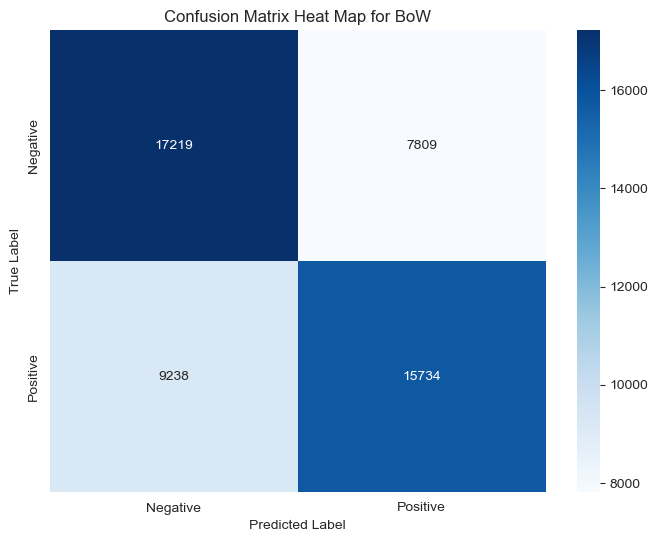

In [18]:
cm_bow = confusion_matrix(y_test, y_pred_bow)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heat Map for BoW')
plt.show()

### KNN menggunakan TF-IDF

In [19]:
knn_tfidf = KNeighborsClassifier(n_neighbors=5)
knn_tfidf.fit(X_train_tfidf, y_train)

KNeighborsClassifier()

In [20]:
y_pred_tfidf = knn_tfidf.predict(X_test_tfidf)

In [21]:
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
print("Logistic Regression with TF-IDF Accuracy:", accuracy_tfidf)
print("Classification Report with TF-IDF:")
print(classification_report(y_test, y_pred_tfidf))

Logistic Regression with TF-IDF Accuracy: 0.67642
Classification Report with TF-IDF:
              precision    recall  f1-score   support

           1       0.70      0.62      0.66     25028
           2       0.66      0.73      0.69     24972

    accuracy                           0.68     50000
   macro avg       0.68      0.68      0.68     50000
weighted avg       0.68      0.68      0.68     50000



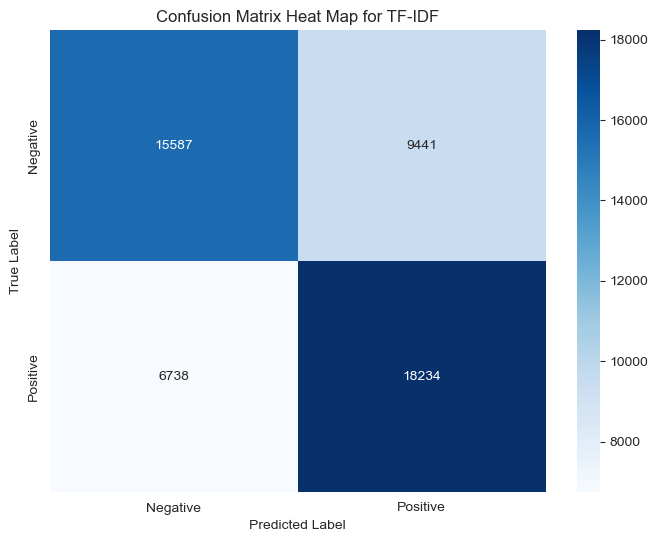

In [22]:
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heat Map for TF-IDF')
plt.show()

### KNN menggunakan Word2Vec

In [23]:
knn_word2vec = KNeighborsClassifier(n_neighbors=5)
knn_word2vec.fit(X_train_word2vec, y_train)

KNeighborsClassifier()

In [24]:
y_pred_word2vec = knn_word2vec.predict(X_test_word2vec)

In [25]:
accuracy_word2vec = accuracy_score(y_test, y_pred_word2vec)
print("Logistic Regression with Word2Vec Accuracy:", accuracy_word2vec)
print("Classification Report with Word2Vec:")
print(classification_report(y_test, y_pred_word2vec))

Logistic Regression with Word2Vec Accuracy: 0.78962
Classification Report with Word2Vec:
              precision    recall  f1-score   support

           1       0.79      0.79      0.79     25028
           2       0.79      0.79      0.79     24972

    accuracy                           0.79     50000
   macro avg       0.79      0.79      0.79     50000
weighted avg       0.79      0.79      0.79     50000



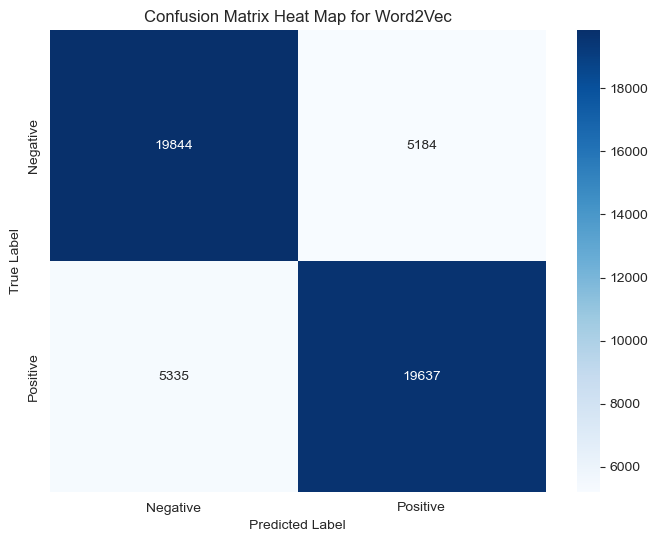

In [26]:
cm_word2vec = confusion_matrix(y_test, y_pred_word2vec)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_word2vec, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heat Map for Word2Vec')
plt.show()

## Perbandingan Model

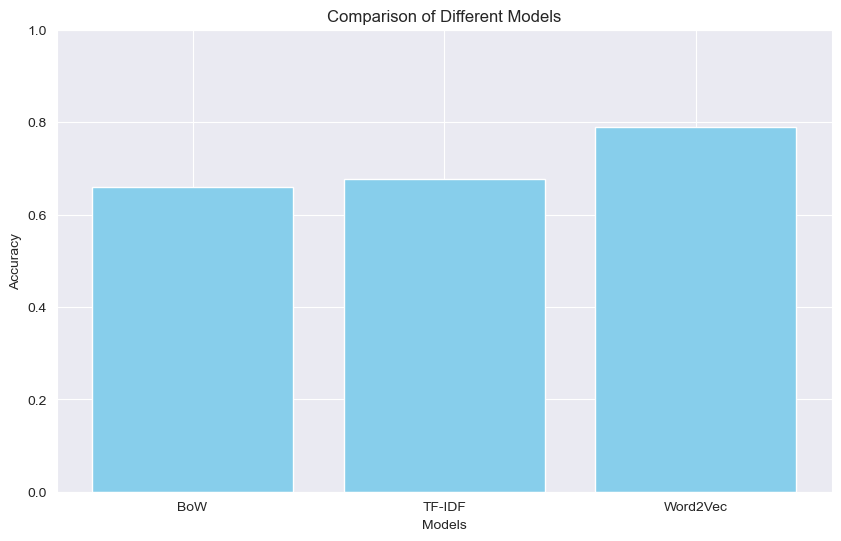

In [27]:
models = ['BoW', 'TF-IDF', 'Word2Vec']
accuracies = [accuracy_bow, accuracy_tfidf, accuracy_word2vec]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Different Models')
plt.ylim(0, 1)
plt.show()